# Data Loading

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path

train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST("./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

def to_numpy_loader(loader):
  for images, labels in loader:
    images = images.cpu()
    labels = labels.cpu()
    yield images.numpy(), labels.numpy()

def one_hot(y, num_classes=10):
  out = np.zeros((y.shape[0], num_classes), dtype=np.float32)
  out[np.arange(y.shape[0]), y] = 1.0
  return out

def normalize(x):
  return x.astype(np.float32)

# Neural Network Definition

In [ ]:
class NeuralNetwork:
  def __init__(self, input_size, hidden_sizes, output_size, activation="relu", lr=0.01):
    self.activation_name = activation
    self.lr = lr
    self.layers = [input_size] + hidden_sizes + [output_size]
    rng = np.random.default_rng()
    self.weights = []
    self.biases = []
    for i in range(len(self.layers) - 1):
      in_dim = self.layers[i]
      out_dim = self.layers[i + 1]
      w = rng.standard_normal((in_dim, out_dim)) * np.sqrt(2 / in_dim)
      b = np.zeros((1, out_dim), dtype=np.float32)
      self.weights.append(w.astype(np.float32))
      self.biases.append(b)

  def activation(self, x):
    if self.activation_name == "relu":
      return np.maximum(0, x)
    if self.activation_name == "sigmoid":
      return 1 / (1 + np.exp(-x))
    return np.tanh(x)

  def activation_grad(self, x):
    if self.activation_name == "relu":
      return (x > 0).astype(np.float32)
    if self.activation_name == "sigmoid":
      s = 1 / (1 + np.exp(-x))
      return s * (1 - s)
    t = np.tanh(x)
    return 1 - t * t

  def softmax(self, x):
    x = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

  def forward(self, x):
    a = x
    self.zs = []
    self.as_ = [a]
    for i in range(len(self.weights)):
      z = a @ self.weights[i] + self.biases[i]
      self.zs.append(z)
      if i < len(self.weights) - 1:
        a = self.activation(z)
      else:
        a = self.softmax(z)
      self.as_.append(a)
    return a

  def compute_loss(self, y_pred, y_true):
    eps = 1e-9
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

  def backward(self, y_true):
    m = y_true.shape[0]
    grads_w = [None] * len(self.weights)
    grads_b = [None] * len(self.biases)
    delta = (self.as_[-1] - y_true) / m
    for i in range(len(self.weights) - 1, -1, -1):
      grads_w[i] = self.as_[i].T @ delta
      grads_b[i] = np.sum(delta, axis=0, keepdims=True)
      if i > 0:
        delta = (delta @ self.weights[i].T) * self.activation_grad(self.zs[i - 1])
    return grads_w, grads_b

  def update_parameters(self, grads_w, grads_b):
    for i in range(len(self.weights)):
      self.weights[i] -= self.lr * grads_w[i]
      self.biases[i] -= self.lr * grads_b[i]

  def predict(self, x):
    probs = self.forward(x)
    return np.argmax(probs, axis=1)

  def evaluate(self, loader):
    losses = []
    correct = 0
    total = 0
    for images_np, labels_np in to_numpy_loader(loader):
      x = normalize(images_np).reshape(images_np.shape[0], -1)
      y = one_hot(labels_np)
      y_pred = self.forward(x)
      losses.append(self.compute_loss(y_pred, y))
      preds = np.argmax(y_pred, axis=1)
      correct += np.sum(preds == labels_np)
      total += labels_np.shape[0]
    return float(np.mean(losses)), float(correct / total)

def train(model, train_loader, val_loader, epochs):
  history = []
  for epoch in range(1, epochs + 1):
    train_losses = []
    train_correct = 0
    train_total = 0
    for images_np, labels_np in to_numpy_loader(train_loader):
      x = normalize(images_np).reshape(images_np.shape[0], -1)
      y = one_hot(labels_np)
      y_pred = model.forward(x)
      loss = model.compute_loss(y_pred, y)
      grads_w, grads_b = model.backward(y)
      model.update_parameters(grads_w, grads_b)
      train_losses.append(loss)
      train_correct += np.sum(np.argmax(y_pred, axis=1) == labels_np)
      train_total += labels_np.shape[0]
    train_loss = float(np.mean(train_losses))
    train_acc = float(train_correct / train_total)
    val_loss, val_acc = model.evaluate(val_loader)
    history.append((epoch, train_loss, train_acc, val_loss, val_acc))
  return history

def run_experiment(config, epochs=5):
  model = NeuralNetwork(784, config["hidden_sizes"], 10, activation=config["activation"], lr=config["lr"]) 
  history = train(model, train_loader, val_loader, epochs)
  return model, history

Path("outputs").mkdir(exist_ok=True)

# Run Experiments

In [ ]:
import pandas as pd

experiments = [
  {"name": "relu_2x128", "hidden_sizes": [128, 128], "activation": "relu", "lr": 0.01},
  {"name": "relu_3x256", "hidden_sizes": [256, 256, 256], "activation": "relu", "lr": 0.01},
  {"name": "sigmoid_2x256", "hidden_sizes": [256, 256], "activation": "sigmoid", "lr": 0.05},
  {"name": "tanh_2x256", "hidden_sizes": [256, 256], "activation": "tanh", "lr": 0.01}
]

all_results = []
for cfg in experiments:
  model, history = run_experiment(cfg, epochs=5)
  for epoch, tr_loss, tr_acc, va_loss, va_acc in history:
    all_results.append([cfg["name"], epoch, tr_loss, tr_acc, va_loss, va_acc])

results_df = pd.DataFrame(all_results, columns=["experiment", "epoch", "train_loss", "train_acc", "val_loss", "val_acc"]) 
results_df.to_csv("outputs/experiment_results.csv", index=False)
print("Experiments completed and results saved!")

# Visualization

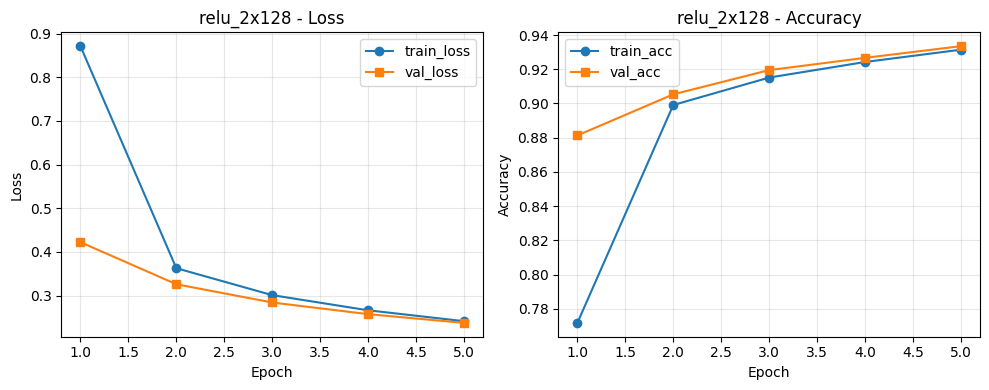

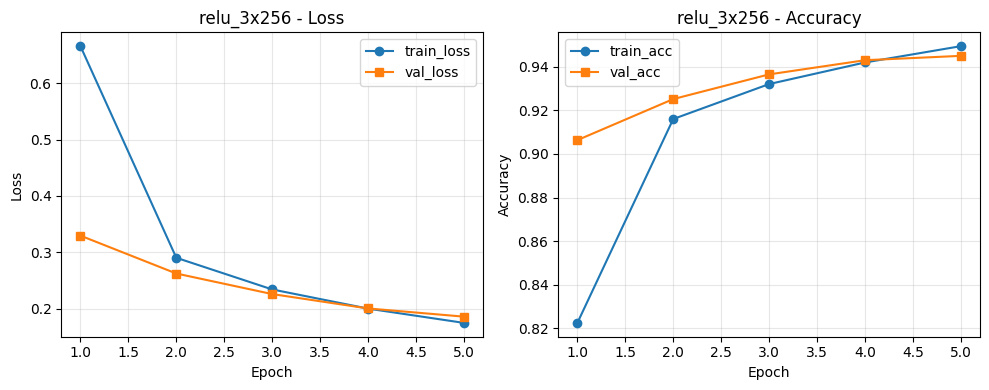

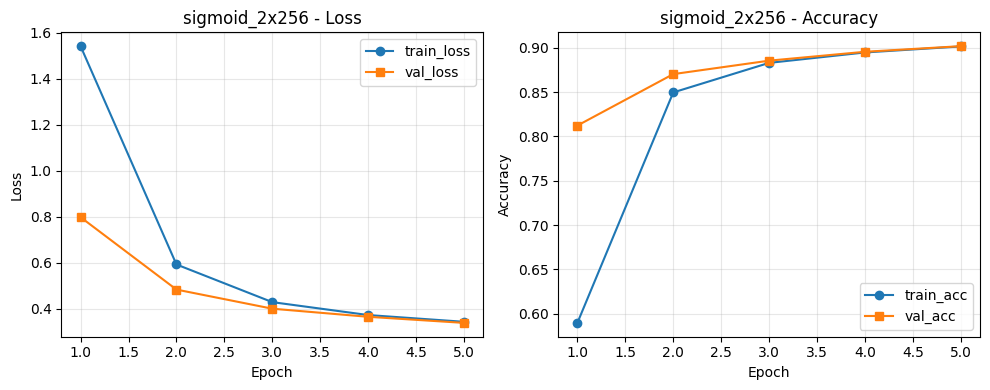

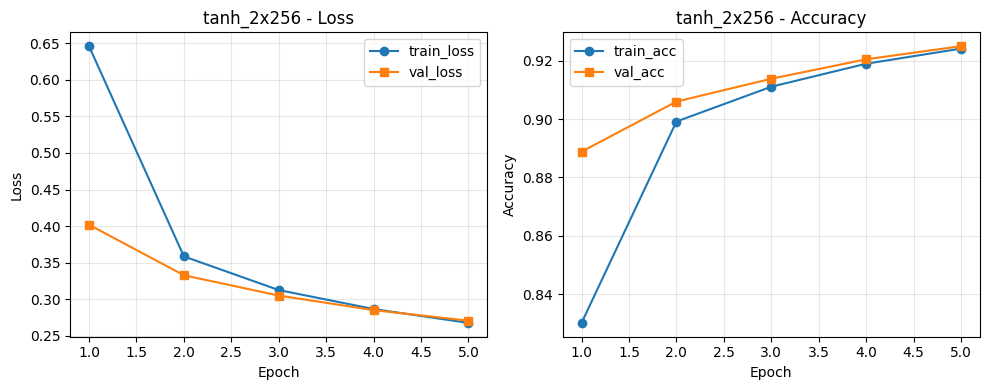


=== Experiment Results Summary ===
               train_loss  train_acc  val_loss   val_acc
experiment                                              
relu_2x128       0.241224   0.931426  0.237317  0.933500
relu_3x256       0.174792   0.949444  0.185872  0.945000
sigmoid_2x256    0.343598   0.901370  0.338892  0.901667
tanh_2x256       0.267440   0.924167  0.270441  0.925000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

results_df = pd.read_csv("outputs/experiment_results.csv")

# Generate plots for each experiment
for name, group in results_df.groupby("experiment"):
  # Loss plot
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(group["epoch"], group["train_loss"], label="train_loss", marker='o')
  plt.plot(group["epoch"], group["val_loss"], label="val_loss", marker='s')
  plt.title(f"{name} - Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid(True, alpha=0.3)
  
  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(group["epoch"], group["train_acc"], label="train_acc", marker='o')
  plt.plot(group["epoch"], group["val_acc"], label="val_acc", marker='s')
  plt.title(f"{name} - Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.savefig(f"outputs/{name}_metrics.png", dpi=100)
  plt.show()
  plt.close()

# Display summary statistics
print("\n=== Experiment Results Summary ===")
print(results_df.groupby("experiment")[["train_loss", "train_acc", "val_loss", "val_acc"]].last())

Relu with Larger Layer Size Performed the best, none of the trained models show signs of overfitting with Validation and Training Accuracy both reaching around 92%